# Kernel methods demo 

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2017 Winter Term 2

Mike Gelbart

In [1]:
import numpy as np
import numpy.random as npr
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from plot_classifier import plot_classifier

%autosave 0

Autosave disabled


### Non-separable data and change of basis

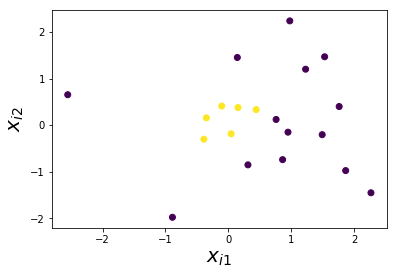

In [2]:
n = 20
d = 2
np.random.seed(0)
X = np.random.randn(n,d)
y = np.sum(X**2,axis=1) < 0.4

plt.scatter(X[:,0], X[:,1], c=y);
plt.xlabel("$x_{i1}$", fontsize=20);
plt.ylabel("$x_{i2}$", fontsize=20);

- The above is not linearly separable.

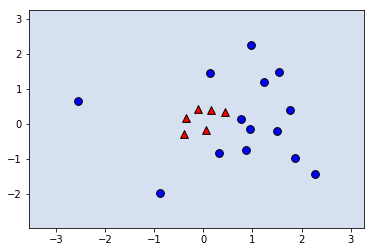

Training accuracy 0.7


In [3]:
svm = SVC(kernel="linear")
svm.fit(X,y)

plot_classifier(X,y,svm)

print("Training accuracy", svm.score(X,y))

Above: we can't perfectly classify all the points with a linear boundary.

But what if we transform the features as follows:

$$z_{i1} = x_{i1}^2$$
$$z_{i2} = x_{i2}^2$$

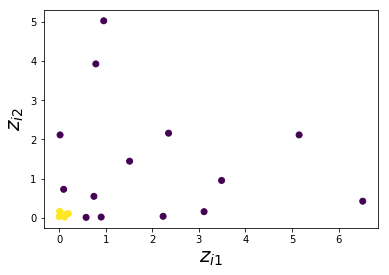

In [17]:
Z = X**2

plt.scatter(Z[:,0], Z[:,1], c=y);
plt.xlabel("$z_{i1}$", fontsize=20);
plt.ylabel("$z_{i2}$", fontsize=20);

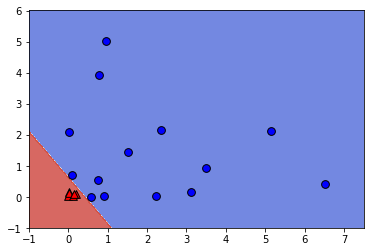

Training accuracy 1.0


In [18]:
svm = SVC(kernel="linear", C=100)
svm.fit(Z,y)

plot_classifier(Z,y,svm)

print("Training accuracy", svm.score(Z,y))

What does this linear boundary in $Z$-space correspond to _in the original ($X$) space_?

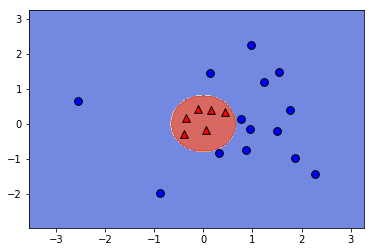

In [24]:
plot_classifier(X, y, svm, transformation=lambda X: X**2);

It's an ellipse!

In [25]:
svm.coef_

array([[-6.3044071 , -4.24523907]])

### RBF SVM hyperparameters $\sigma$ and $\lambda$

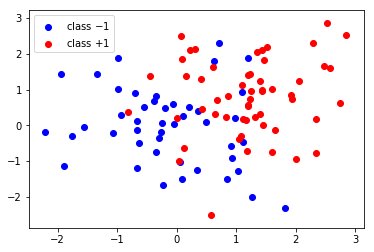

In [26]:
# generate synthetic 2D data set
n = 100
X = npr.randn(n,2)
y = npr.choice((-1,+1),size=n)
X[y>0] += 1

plt.scatter(X[y<0,0], X[y<0,1], color="b", label="class $-1$")
plt.scatter(X[y>0,0], X[y>0,1], color="r", label="class $+1$")
plt.legend(loc="best")
plt.show()

- Larger `gamma` leads to more complex boundaries (in our notation, this hyperparameter is $\frac{1}{\sigma}$. 
- Larger `C` means less regularization (in our notation, this hyperparameter is $\frac{1}{\lambda}$.

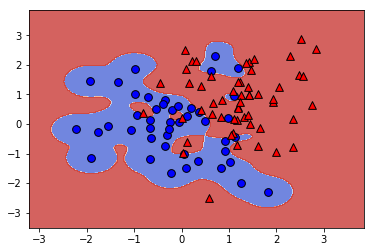

In [27]:
svm = SVC(kernel="rbf", gamma=10, C=10)
svm.fit(X,y)
plot_classifier(X, y, svm)

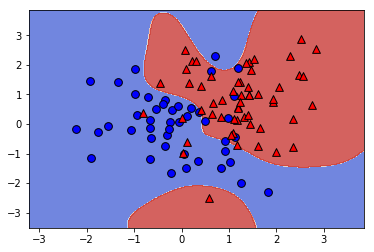

In [29]:
svm = SVC(kernel="rbf", gamma=1, C=10) # larger length scale (sigma)
svm.fit(X,y)
plot_classifier(X, y, svm)

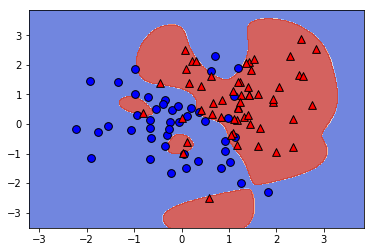

In [30]:
svm = SVC(kernel="rbf", gamma=1, C=1000) # less regularization
svm.fit(X,y)
plot_classifier(X, y, svm)

You can think of `gamma` as controlling the abruptness at which we can change the class, whereas `C` controls how much we worry about making errors.

### The interaction between hyperparameters

In [31]:
gamma_min = -3
gamma_max = 3
C_min = -3
C_max = 3
gamma_grid = 10.0**np.arange(gamma_min,gamma_max+1)
C_grid = 10.0**np.arange(C_min,C_max+1)
train_errors = np.zeros((len(gamma_grid),len(C_grid)))
valid_errors = np.zeros((len(gamma_grid),len(C_grid)))

X_train, X_valid, y_train, y_valid = train_test_split(X,y)

for i,gamma in enumerate(gamma_grid):
    for j,C in enumerate(C_grid):
        svm = SVC(kernel="rbf", gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        train_errors[i,j] = 1-svm.score(X_train,y_train)
        valid_errors[i,j] = 1-svm.score(X_valid,y_valid)

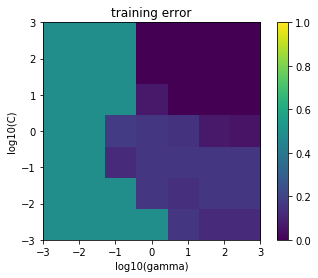

In [32]:
plt.imshow(train_errors,origin="lower",vmin=0,vmax=1,extent=(gamma_min,gamma_max,C_min,C_max))
plt.xlabel('log10(gamma)')
plt.ylabel('log10(C)')
plt.title('training error')
plt.colorbar();

Above: as expected, we get the best training error with the least regularization and the smallest (wildest) $\sigma$.

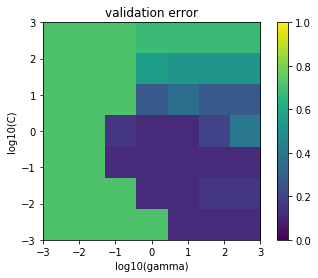

In [33]:
plt.imshow(valid_errors,origin="lower",vmin=0,vmax=1,extent=(gamma_min,gamma_max,C_min,C_max))
plt.xlabel('log10(gamma)')
plt.ylabel('log10(C)')
plt.title('validation error')
plt.colorbar();

- However, the situation changes for validation error. 
- Furthermore, the hyerparameters interact with each other
  - If we set `C=1` and optimized `gamma`, we'd get something non-optimal.

---------

The rest is for fun, if we have time...



---------

### What is regularization actually doing?

- It seems like `gamma` matters more than `C`
- The effect of `C` is somewhat subtle

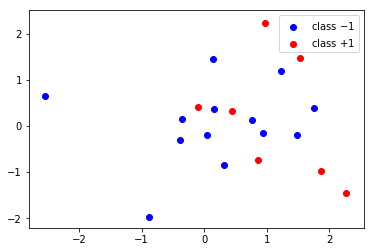

In [34]:
# generate synthetic 2D data set
npr.seed(0)
n = 20
X = npr.randn(n,2)
y = npr.choice((-1,+1),size=n)

plt.scatter(X[y<0,0], X[y<0,1], color="b", label="class $-1$")
plt.scatter(X[y>0,0], X[y>0,1], color="r", label="class $+1$")
plt.legend(loc="best")
plt.show()

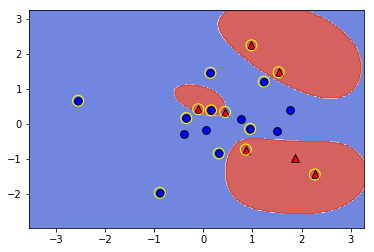

In [35]:
svm = SVC(kernel="rbf", gamma=1, C=10)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

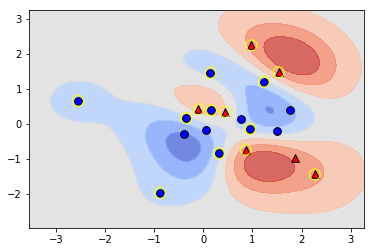

In [36]:
plot_classifier(X, y, svm, ax=plt.gca(), proba=True) # plot raw model output (not really probabilities)
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

We'd expect more regularization to correspond to simpler models, meaning that if we increase the regularization strength we might be able to get rid of one of the "islands" of red. 

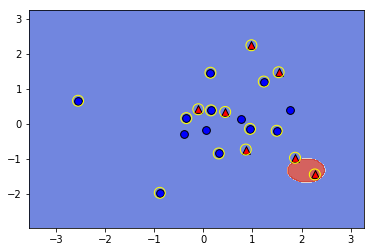

In [37]:
svm = SVC(kernel="rbf", gamma=1, C=.5)
svm.fit(X,y)
plot_classifier(X, y, svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120); 

Above: by increasing the regularization, we got the "island" in the upper-right to disappear from the classification surface, but since those two red points are still support vectors (yellow circles), they are still affecting the raw model output, as shown below.

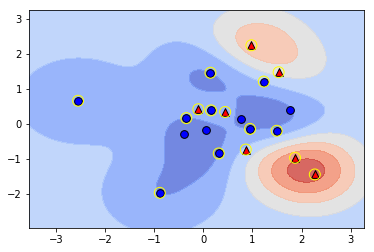

In [38]:
plot_classifier(X, y, svm, ax=plt.gca(), proba=True) # plot decision function (not probabilities)
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

### RBF kernel vs. RBF features

Next we'll try to show how the RBF kernel relates to the RBF features. We implement the RBF features (from Lecture 14) below, and compare with the above. 

In [ ]:
svm = SVC()
svm.fit(X,y)
plot_classifier(X, y, svm)

In [ ]:
# from hw2 code
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)

def RBF_features(Xtrain, Xtest, sigma=1):
    return np.exp(-0.5*euclidean_dist_squared(Xtest,Xtrain)/(sigma**2))

Z = RBF_features(X,X)
svm2 = SVC(kernel="linear")
svm2.fit(Z,y)
plot_classifier(X, y, svm2, transformation=lambda Xtest: RBF_features(X,Xtest))

They look pretty similar. 

## Polynonial kernel vs. polynomial features

Unlike the RBF case, these should be exactly the same

In [28]:
x = np.random.rand(10)
y = x**2 + np.random.randn(10)*.1

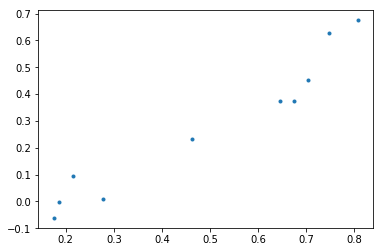

In [29]:
plt.plot(x,y,'.');

In [100]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

k=10  # polynomial degree
λ=1e-10 # L2 regularization strength

X = x[:,None]
pf = PolynomialFeatures(degree=k)
Z = pf.fit_transform(X)

ridge = Ridge(alpha=λ, fit_intercept=False) 
# fit_intercept=False because features already include intercept feature
# could alternatively set include_bias=False for the PolynomialFeatures
ridge.fit(Z,y)

Ridge(alpha=1e-10, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

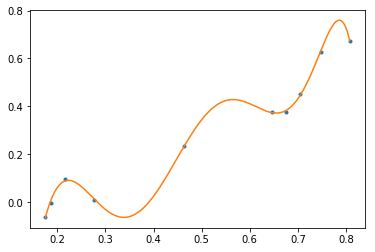

In [101]:
# grid = np.linspace(0,1,1000)[:,None]
grid = np.linspace(np.min(x),np.max(x),1000)[:,None]
plt.plot(x,y,'.')
plt.plot(grid, ridge.predict(pf.transform(grid)));

In [102]:
ridge.coef_

array([  -8.69875532,  115.83751239, -537.66048539,  969.97161985,
       -267.15062703, -731.70669641, -121.11252696,  510.05664086,
        568.35284076,   85.55754043, -639.17807399])

#### And now the same with a kernel

In [121]:
kr = KernelRidge(alpha=λ, kernel='polynomial', degree=k)
kr.fit(X,y)

KernelRidge(alpha=1e-10, coef0=1, degree=10, gamma=None, kernel='polynomial',
      kernel_params=None)

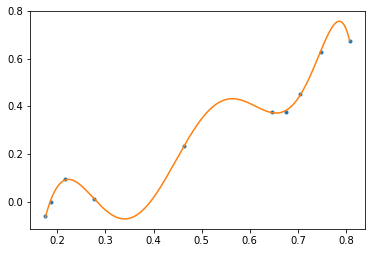

In [122]:
plt.plot(x,y,'.')
plt.plot(grid, kr.predict(grid));